In [ ]:
# inspired by lazyprogrammer


import pandas as pd
import matplotlib.pyplot as plt

import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances



In [ ]:
df = pd.read_csv('tmdb_5000_movies.csv')

In [ ]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
x = df.iloc[0]
x

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
id                                                                  19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [ ]:
x['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [ ]:
x['keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [ ]:
j = json.loads(x['genres'])
j

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [ ]:
' '.join(''.join(jj['name'].split()) for jj in j)

'Action Adventure Fantasy ScienceFiction'

In [ ]:
def genres_and_keywords_to_string(row):
  '''
  convert the relevant data for each movie into a single string to be ingested by TfidfVectorizer
  '''
  
  genres = json.loads(row['genres'])
  genres = ' '.join(''.join(j['name'].split()) for j in genres)

  keywords = json.loads(row['keywords'])
  keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
  
  
  return f"{genres} {keywords}"


In [ ]:
df['string'] = df.apply(genres_and_keywords_to_string, axis=1)  # create a new string representation of each movie

In [ ]:
tfidf = TfidfVectorizer(max_features=2000)

In [ ]:
X = tfidf.fit_transform(df['string'])

In [ ]:
X

<4803x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 37285 stored elements in Compressed Sparse Row format>

In [ ]:
movie2idx = pd.Series(df.index, index=df['title'])    # map from movie title -> index (in df)
movie2idx

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [ ]:
idx = movie2idx['Scream 3']
idx

1164

In [ ]:
query = X[idx]
query

<1x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [ ]:
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
scores = cosine_similarity(query, X)
scores

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
scores = scores.flatten()    # (1 x N) --> 1-D array

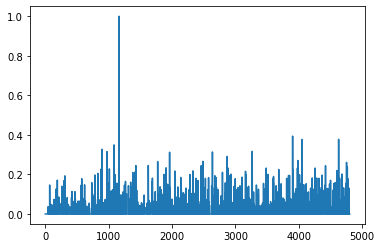

In [ ]:
plt.plot(scores);


In [ ]:
(-scores).argsort()

array([1164, 3902, 4628, ..., 1714, 1720, 4802])

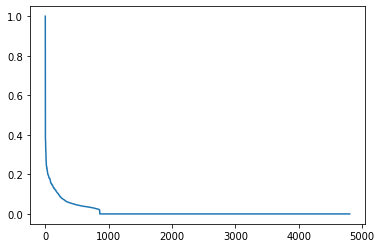

In [ ]:
plt.plot(scores[(-scores).argsort()]);

In [ ]:
# top 5 matches
# exclude self (similarity between query and itself yields max score)

recommended_idx = (-scores).argsort()[1:6]


In [ ]:
df['title'].iloc[recommended_idx]    # convert indices back to titles

3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object

In [ ]:
def recommend(title):

  idx = movie2idx[title]

  if type(idx) == pd.Series:
    idx = idx.iloc[0]

  query = X[idx]
  scores = cosine_similarity(query, X)

  scores = scores.flatten()

  recommended_idx = (-scores).argsort()[1:6]



  return df['title'].iloc[recommended_idx]
  

In [ ]:
print("Recommendations for 'Scream 3':")

print(recommend('Scream 3'))


Recommendations for 'Scream 3':
3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object


In [ ]:
print("Recommendations for 'Mortal Kombat':")

print(recommend('Mortal Kombat'))


Recommendations for 'Mortal Kombat':
1611              Mortal Kombat: Annihilation
1670                       DOA: Dead or Alive
3856              In the Name of the King III
1001    Street Fighter: The Legend of Chun-Li
2237                        Alone in the Dark
Name: title, dtype: object


In [ ]:
print("Recommendations for 'Runaway Bride':")

print(recommend('Runaway Bride'))


Recommendations for 'Runaway Bride':
4115                    House of D
2325    My Big Fat Greek Wedding 2
4604         It Happened One Night
3313                  An Education
2689            Our Family Wedding
Name: title, dtype: object
